In [122]:
import numpy as np
import pandas as pd
import scipy.misc
import pywt
from pywt import cwt
import matplotlib.pyplot as plt
import cv2 as cv
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms , models
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
num_classes = 3
Fs = 128
factor = 64
images_per_patient = factor
duration = 512 / factor 

<span style="font-size:24pt; color:blue">part 1 - wavelet transform </span>
##### In this part, we read ECG data for 162 patients. Each ECG signal has a length of 512 seconds and is sampled at 128 Hz. We preprocess each signal using wavelet transform and create scalograms for the whole 512 seconds. Additionally, we break each signal into four segments of 128 seconds each, eight segments of 64 seconds each, and 64 segments of 8 seconds each. We apply wavelet transform to each segment and create scalograms for each segment. We then save all the scalograms as images to the PC memory.
##### It's important to note that there is no call for the function that creates the scalogram in this section. If someone wants to create the scalograms, they must call the function themselves to generate the files on their computer. This applies to all scalograms, including those created for the whole 512 seconds and the scalograms created for each of the four, eight, and sixty-four segments of each signal
###### each scalogram is a RGB image shaped 224 X 224 X 3

In [2]:
def readECG():
    """
    reads the ECGdata and ECGlabels files
    assumes these files are CSV files in
    directory './ECGdata directory' .
    
    Returns
    -------
    ECGdata:
            np.2darray - the ECG signals.
            shaped (number of ECG signals, number of samples of each signal)
    ECGdata:
            np.1darray of strings - the labels. 
    """
    ECGdata = pd.read_csv(os.path.join("." ,"ECGdata", "data.csv"), header=None)
    ECGlabels = pd.read_csv(os.path.join("." ,"ECGdata", "labels.csv"), header=None)
    ECGdata = ECGdata.to_numpy()
    ECGlabels = np.squeeze(ECGlabels.to_numpy())
    print ('ECGdata: ' , type(ECGdata) , '\n' , 'shape: ' , ECGdata.shape)
    print ('ECGlabels: ' ,  type(ECGlabels) , '\n' , 'shape: ' , ECGlabels.shape)
    return ECGdata, ECGlabels

In [3]:
def createDirectories(duration, b, c):
    """
        after calling to this function, the directory contains the code.py file will have in it a
        directory named 'data' and in 'data' three sub directories : 'ARR' ,'CHF' and 'NSR'
        
        returns:
        a dictionary 'dir_path' with labels names as keys, and path to the relevant directory from the
        directory that contains the code.py file.

    """
    
    #create the data directory if does not exists alredy
    data_dir_path = "./data_duration_" + str(duration) + "_b" + str(b) + "_c" + str(c)   
    if not os.path.exists(data_dir_path):
        os.mkdir(data_dir_path)
          
    #dictinary where the keys are the labels names and values are boolian: directory of this label exists / does not exists
    existsDirectory = {
        "ARR": os.path.exists(os.path.join(data_dir_path, "ARR")),
        "CHF": os.path.exists(os.path.join(data_dir_path, "CHF")),
        "NSR": os.path.exists(os.path.join(data_dir_path, "NSR")),
    }
    
    #dictinary where the keys are the labels names and values are the corresponding directory path
    dir_path = {
        "ARR": os.path.join(data_dir_path, "ARR"),
        "CHF": os.path.join(data_dir_path, "CHF"),
        "NSR": os.path.join(data_dir_path, "NSR")
    }
    
    #create the sub directories that do not exists alredy

    for dir_name in existsDirectory:
        if existsDirectory[dir_name] == False: 
            os.mkdir(dir_path[dir_name])
            
            
    return dir_path

In [4]:
def plotSignalAndScalogram(signal, duration ,label, msg = '', B = 1.5 ,C = 2 ,fmin = 1, fmax = 64) :
    """
    gets an ECG signal and it's label, calls a function to compute its scalogram
    and prints the signal and it's scalogram to the screen.

    Parameters
    ----------
    signal:
        np.1darray
    Fs:
        double, sampling frequency of the ECG signal
    duration:
        double, duration in secs.
    label:
        string.
    """    
    coef_abs = computeCwt(signal ,B, C, fmin, fmax)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    samples_number = len(signal)
    fig.suptitle((label + ' ECG signal and its scalogram' + '\n' + msg), size = 'xx-large', color = 'teal')
    t = np.linspace (0, duration, num = samples_number)
    plotSignal(ax1, t, signal, duration)
    showScalogram(ax2, coef_abs, duration, fmin, fmax)
    
    
    
def plotSignal(ax, t, sig, duration):
    """
        helper function to plotSignalAndScalogram
    """
    ax.plot(t, sig)
    ax.set_xlabel('Time [sec]', size = 'medium')
    ax.set_ylabel('Volatage [mV]', size = 'large')
    ax.set_xlim(0, duration)
    ax.grid()
    
    
    
def showScalogram(ax, abs_cwtmatr, duration, fmin = 1, fmax = 64):
    """
        helper function to plotSignalAndScalogram
    """
    # Use the matshow function to display the plot using matshow on the specified axis
    ax.matshow(abs_cwtmatr, extent=[0, duration, fmin, fmax], 
               cmap='jet', aspect='auto')

    # Customize the appearance of the plot using various options provided by the matplotlib library
    ax.set_ylabel('Frequency [Hz]', size = 'large')

In [5]:
def cutSignal(signal, start_time, stop_time, Fs):
    first_sample = int (Fs * start_time) 
    last_sample = int (Fs * stop_time) 
    return signal[first_sample : last_sample]

In [6]:
def computeCwt(signal, B  ,C  , fmin, fmax):
    """
    gets a signal and parameters, and computes the signal continius wavelet transform
    uses a complex morlet as a mother wavelet and returns the absoulue value of the coefficients.
    
    Parameters
    ----------
    
    signal:
        np.1darray
      
    B :
        int, bandwith of the complex morlet

    C:  
        int, centeral frequency of the complex morlet
    
    fmin:
        double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
        double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.

    Returns
    -------
    
    coef_abs :
        np.2darray of real numbers shaped (len(signal), fmax - fmin) 
    """
    scales = np.arange(fmin, fmax)
    wavelet = f'cmor{B}-{C}'
    coef, _ = cwt(signal, scales, wavelet)
    coef_abs = np.abs(coef)
    return coef_abs

In [7]:
def getRGB_224_224_3(coef_abs):
    """
    gets coefficients matrix , uses a cmap and returns 224 X 224 X 3 RGB image 
    
    Parameters
    ----------
    coef_abs : np.2darray of real numbers, the cwt coefs absoulute value  
    

    Returns
    -------
    
    RGB_224_224_3 : np.3darray of uint8 shaped (224,224,3)        
    """
    cmap = plt.get_cmap('jet')

    # Normalize the cwt array to the range [0, 1]
    cwt_normalized = (coef_abs - coef_abs.min()) / (coef_abs.max() - coef_abs.min())

    # Create an RGB image using the cmap and the normalized cwt array
    rgb_image = cmap(cwt_normalized)
    rgb_image = np.delete(rgb_image, 3, 2)
    rgb_image = (rgb_image * 255).astype('uint8')
    # Resize the image to 224 x 224
    resized_image = cv.resize(rgb_image, (224, 224))
    resized_image = cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)
    RGB_224_224_3 = resized_image
    return RGB_224_224_3

In [8]:
def writeScalogramToDir(rgb_scalogram,labels,dir_path,index):
    """
        helper function to createScalogramsAndWriteToDir

    """
    output_path = os.path.join(dir_path[labels[index]], labels[index] + '_' + str(index) + '.png')
    cv.imwrite(output_path, rgb_scalogram)

In [9]:
def createScalogramsAndWriteToDir(data, labels,signal_duration, fmin = 1, fmax = 64, B = 1.5, C = 2):
    """
    create a directory for each label,
    gets the ECG signals and parameters, compute each signal cwt,converts the resulted scalogram to 
    a 224 X 224 X 3 RGB image, and writes the image to the directory associated to the ECG signal label . 
    
    Parameters
    ----------
    
    data:
            np.2darray - the ECG signals.
            shaped (number_of_ECG_signals,number_of_samples_of each signal)
    labels:
            np.1darray of strings - the labels.
            
    fmin:
            double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
            double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.
      
    B :
        int, bandwith of the complex morlet

    C:  
        int, centeral frequency of the complex morlet
    """
    dir_path = createDirectories(signal_duration,B , C)    
    for i in range(len(labels)):
        signal = data[i, :]
        coef_abs = computeCwt(signal, B, C, fmin, fmax)
        rgb_scalogram = getRGB_224_224_3(coef_abs)
        writeScalogramToDir(rgb_scalogram, labels, dir_path, i)

In [10]:
def divide2MoreExamples (origData, origLabels,duration,Fs):
    factor = int(origData.shape[1] / (Fs * duration))
    print ('Each of the original signals is divided into ', factor , 'signals')
    print ('origData.shape = ',origData.shape)
    newData = np.reshape(origData, (origData.shape[0] * factor, -1))
    newLabels = np.repeat(origLabels,factor)
    print ('newData.shape: ' , newData.shape)
    print ('newLabels.shape: ' , newLabels.shape)
    return factor, newData, newLabels

In [11]:
def show3classes(ARR_index, CHF_index, NSR_index, data, labels, duration):
    assert (labels[ARR_index] == 'ARR' and labels[CHF_index] == 'CHF' and labels[NSR_index] == 'NSR')
    for index in [ARR_index,CHF_index,NSR_index]:
        signal, label = data[index,:], labels[index]
        plotSignalAndScalogram(signal, duration ,label, 'index: ' + str(index))

In [12]:
def newIndices (factor,lastArrOrigIndex,lastCHFOrigIndex):
    ARR_LastIndex = (lastArrOrigIndex + 1) * factor - 1
    CHF_FirstIndex = (lastArrOrigIndex + 1) * factor 
    NSR_FirstIndex = (lastCHFOrigIndex + 1) * factor
    return ARR_LastIndex, CHF_FirstIndex, NSR_FirstIndex

In [13]:
def divideAndExhibit(origData, origLabels,duration, Fs):
    factor, data, labels = divide2MoreExamples(ECGdata, ECGlabels, duration, Fs)
    lastArrOrigIndex, lastCHFOrigIndex  = 95, 125
    ARR_LastIndex, CHF_FirstIndex, NSR_FirstIndex = newIndices(factor,lastArrOrigIndex,lastCHFOrigIndex)
    show3classes(ARR_LastIndex, CHF_FirstIndex,NSR_FirstIndex,data, labels, duration)
    return data, labels

In [14]:
ECGdata, ECGlabels = readECG ()

ECGdata:  <class 'numpy.ndarray'> 
 shape:  (162, 65536)
ECGlabels:  <class 'numpy.ndarray'> 
 shape:  (162,)


Each of the original signals is divided into  64 signals
origData.shape =  (162, 65536)
newData.shape:  (10368, 1024)
newLabels.shape:  (10368,)


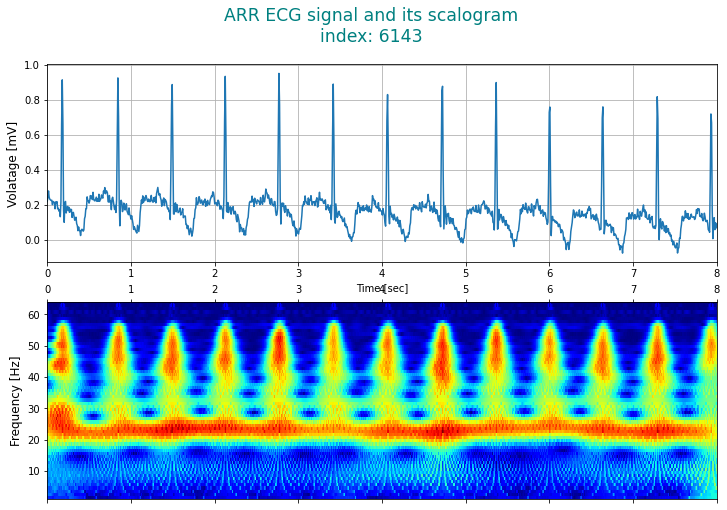

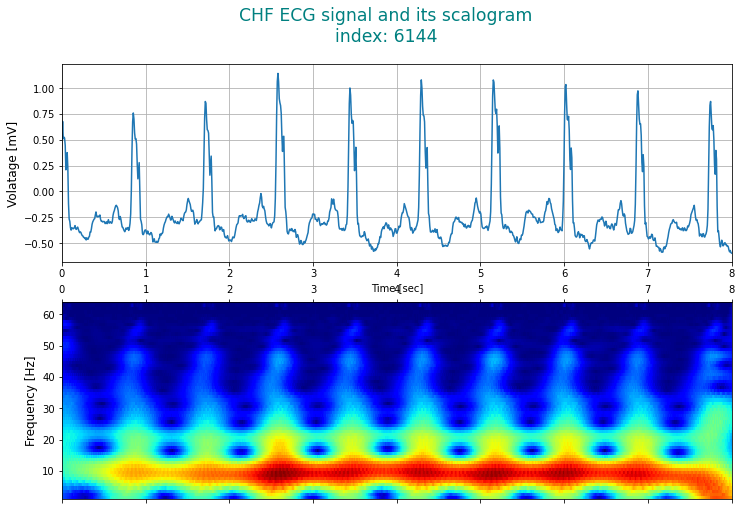

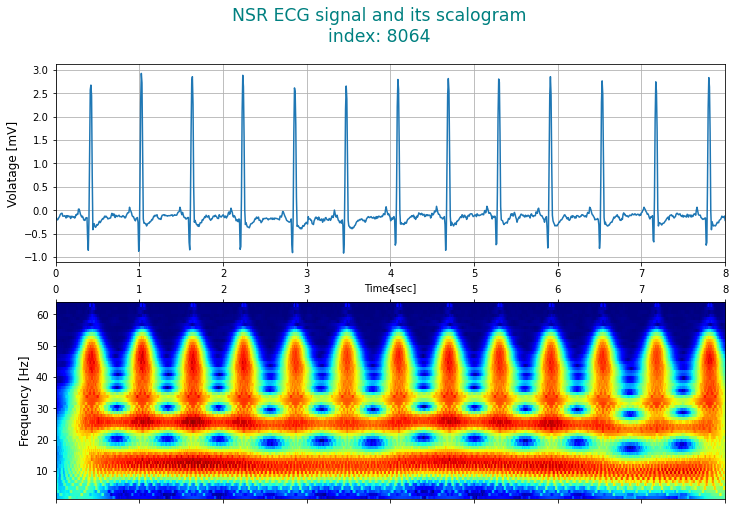

In [15]:
data, labels = divideAndExhibit(ECGdata,ECGlabels,duration,Fs) 

In [16]:
#createScalogramsAndWriteToDir(data,labels,duration, B = 1.5,C = 2)
# if you dont have the files on your pc, you must call this function with durations of 512, 128, 64, and 8

<span style="font-size:24pt; color:blue">part 2 - CNN </span>
###### We utilize the ResNet  architecture to train three different models, each trained on a different scalogram length, namely,  128 seconds, 64 seconds, and 8 seconds. We use the scalograms generated from Part 1 and their corresponding ground truth to train, validate, and test each model. It is worth noting that each model only works with a specific scalogram length.
###### To train each model, we take the scalogram images generated from Part 1 and preprocess them using PyTorch dataset and dataloader . We train each model with its specific scalogram length, and save each model to the PC memory.
###### It is essential to highlight that there is no code available here that trains all four models at once. Instead, there is a code that trains a single model that works with a specific scalogram length. Therefore, to run the code, we need to train the four models on the four different scalogram lengths, specifying the root directory where the scalograms of each length are located, as generated in Part 1.
###### We aim to train each of the four models to achieve a test score of approximately 0.95.
###### To ensure an unbiased evaluation of the model performance, we partition each of the 162 patients into separate train, validation, and test sets based on their original patient ID. That is, all of a patient's scalograms belong to only one set to avoid contamination of the test or validation sets by the training set.

In [17]:
def find_mean_std(root):
    # Initialize variables
    sum_b, sum_g, sum_r = 0, 0, 0
    num_pixels = 0
    std_b_list = []  # Create a list to store standard deviations

    # Define your path

    # Loop through subfolders
    for subdir in os.listdir(root):
        subdir_path = os.path.join(root, subdir)
        if os.path.isdir(subdir_path):  # check if it's a subdirectory
        # Loop through images
            for filename in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, filename)
                # Load the image
                img = cv.imread(file_path) / 255
                # Add up the channels
                sum_b += np.sum(img[:, :, 0])
                sum_g += np.sum(img[:, :, 1])
                sum_r += np.sum(img[:, :, 2])
                # Count the pixels
                num_pixels += img.shape[0] * img.shape[1]
                # Calculate the standard deviation for each image and append to list
                std_b_list.append(np.std(img[:, :, 0]))
        
    # Calculate the means for each channel
    mean_b = sum_b / num_pixels
    mean_g = sum_g / num_pixels
    mean_r = sum_r / num_pixels

    # Calculate the standard deviation for blue channel
    std_b_array = np.array(std_b_list)
    # Check if all values in array are zero or NaN, and replace with default value if necessary
    if (std_b_array <= 0).any() or np.isnan(std_b_array).any():
        std_b = 1
    else:
        std_b = np.mean(std_b_array)

    # Calculate the standard deviation for green channel
    std_g_array = np.std(img[:, :, 1])
    # Check if all values in array are zero or NaN, and replace with default value if necessary
    if (std_g_array <= 0).any() or np.isnan(std_g_array).any():
        std_g = 1
    else:
        std_g = np.mean(std_g_array)

    # Calculate the standard deviation for red channel
    std_r_array = np.std(img[:, :, 2])
    # Check if all values in array are zero or NaN, and replace with default value if necessary
    if (std_r_array <= 0).any() or np.isnan(std_r_array).any():
        std_r = 1
    else:
        std_r = np.mean(std_r_array)
    return ([mean_r, mean_g, mean_b], [std_r,std_g,std_b])

In [18]:
def sort_key_fn(filename):
    parts = filename.rsplit("_", 1)
    return int(parts[1].split(".")[0])

In [19]:
def default_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [20]:
def loadData(root):
    labels = os.listdir(root)
    mean, std = find_mean_std(root)
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
    dataset = ImageFolder(root, transform=transform, target_transform=None, is_valid_file=None, loader=default_loader)
    dataset.samples = sorted(dataset.samples, key=lambda x: sort_key_fn(os.path.basename(x[0])))
    idx_to_class = {}
    for key, value in dataset.class_to_idx.items():
        idx_to_class[value] = key
    return dataset, idx_to_class

In [21]:
def createDataLoaders(dataset,factor):
    dataset_size = len(dataset)
    train_indices = list(range(0, 59 * factor)) + list(range(96 * factor, 114 * factor)) + list(range(126 * factor, 148 * factor))
    val_indices = list(range(59 * factor, 78 * factor)) + list(range(114 * factor, 120 * factor)) + list(range(148 * factor, 155 * factor))
    test_indices = list(range(78 * factor, 96 * factor)) + list(range(120 * factor, 126 * factor)) + list(range(155 * factor, dataset_size))
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)
    train_loader = DataLoader(train_dataset, batch_size=22, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    loaders = [train_loader, val_loader, test_loader]
    return loaders, train_loader, val_loader, test_loader

In [22]:
def create_val_test_indexes_dicts(factor):
    val_loader_to_dataset_idx = {}
    for i in range(19 * factor):
        val_loader_to_dataset_idx[i] = 59 * factor + i
    for i in range(19 * factor, 25 * factor):
        val_loader_to_dataset_idx[i] = 114 * factor + i - 19 * factor
    for i in range(25 * factor, 32 * factor):
        val_loader_to_dataset_idx[i] = 148 * factor + i - 25 * factor
        
    test_loader_to_dataset_idx = {}
    for i in range(18 * factor):
        test_loader_to_dataset_idx[i] = 78 * factor + i
    for i in range(18 * factor, 24 * factor):
        test_loader_to_dataset_idx[i] = 120 * factor + i - 18 * factor
    for i in range(24 * factor, 31 * factor):
        test_loader_to_dataset_idx[i] = 155 * factor + i - 24 * factor
    
    train_loader_to_dataset_idx = {}
    for i in range(59 * factor):
        train_loader_to_dataset_idx[i] = i
    for i in range(59 * factor, 77 * factor):
        train_loader_to_dataset_idx[i] = 96 * factor + i - 59 * factor
    for i in range(78 * factor, 100 * factor):
        train_loader_to_dataset_idx[i] = 126 * factor + i - 78 * factor
    return (train_loader_to_dataset_idx, val_loader_to_dataset_idx, test_loader_to_dataset_idx)

In [23]:
def loadersInfo(loaders, idx_to_class):
    train_loader , val_loader, test_loader = loaders
    for idx, clas in idx_to_class.items():
        print ('index ',idx ,' corresponding to class ',clas, ' in the dataset')
    print ('number of train batches: ', len(train_loader))
    print ('each batch contains ',train_loader.batch_size,'examples')
    print ('length of val_loader: ',len(val_loader), '(' + str(int(len(val_loader) / images_per_patient)) + ' different patients)')
    print ('length of test_loader: ',len(test_loader) , '(' + str(int(len(test_loader) / images_per_patient)) +' different patients)')

In [24]:
def predict_image(image, model):
    model.eval()
    with torch.no_grad():
        output = model(image)
    prediction = torch.max(output, 1)[1].item()
    return prediction

In [25]:
def predict_loader(loader, model):
    predictions = []
    labels = []
    for (image, label) in loader:
        prediction = predict_image(image, model)
        predictions.append(prediction)
        labels.append(label.item())
    return predictions, labels

In [26]:
def print_spectogram_from_dataset(dataset,idx,message = None):
    mean, std = find_mean_std(root)
    image, label = dataset[idx]
    print("Ground Truth Label:", idx_to_class[label])
    print ("index", idx, "in the root folder, belongs to patient indexed", int(idx/factor))
    if message != None:
        print(message)
    inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
    image = inv_normalize(image.squeeze())
    plt.imshow(transforms.functional.to_pil_image(image))
    plt.show()

In [27]:
def evaluate_image(image, model):
    model.eval()
    image = image.unsqueeze(0)
    with torch.no_grad():
        output = torch.softmax(model(image), dim=1)
    return output

In [28]:
def print_confusion_matrix(loader, model, predictions, labels):
    confusion_matrix = np.zeros((num_classes, num_classes))
    for i in range(len(labels)):
        confusion_matrix[labels[i], predictions[i]] += 1
    print ("confusion matrix:")
    print(confusion_matrix)
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print('Accuracy:', accuracy)

In [29]:
def print_misclassified_images (loader, model,loader_to_dataset_dict, loader_predictions, loader_labels):
    print ("\n misclassified images \n")
    for index in range(len(loader_labels)):
        if loader_predictions[index] != loader_labels[index]:
            print("Misclassified image :")
            image = dataset[loader_to_dataset_dict[index]][0]
            print ('\nmodel prediction:')
            print(evaluate_image(image, model))
            print_spectogram_from_dataset(dataset,loader_to_dataset_dict[index],message = "Predicted label:" + idx_to_class[loader_predictions[index]])

In [30]:
def print_loader_results(loader, model, loader_to_dataset_dict, elaboration_level = 'low'):
    print(images_per_patient, "images per patient analysis:")
    loader_multiple_predicions_per_patient , loader_labels =  predict_loader(loader, model)
    print_confusion_matrix(loader, model, loader_multiple_predicions_per_patient, loader_labels)
    if (elaboration_level == 'high'):  
        print_misclassified_images(loader, model, loader_to_dataset_dict, loader_multiple_predicions_per_patient, loader_labels)

### prepare the data

In [31]:
factor = 4
images_per_patient = factor
duration = int(512 / factor)
root = './data_duration_{}_b1.5_c2'.format(duration)
train_loader_to_dataset_idx, val_loader_to_dataset_idx, test_loader_to_dataset_idx = create_val_test_indexes_dicts(factor)
dataset, idx_to_class = loadData(root)
loaders, train_loader, val_loader, test_loader = createDataLoaders(dataset,factor)
loadersInfo(loaders, idx_to_class)

index  0  corresponding to class  ARR  in the dataset
index  1  corresponding to class  CHF  in the dataset
index  2  corresponding to class  NSR  in the dataset
number of train batches:  18
each batch contains  22 examples
length of val_loader:  128 (32 different patients)
length of test_loader:  124 (31 different patients)


### define the model

In [32]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

### train the model

Epoch 1 train loss: 0.9878 val loss: 0.9259 train accuracy: 0.5783 val accuracy: 0.6875 time: 189.5208 s
Epoch 6 train loss: 0.1914 val loss: 0.3510 train accuracy: 0.9874 val accuracy: 0.8984 time: 182.5456 s
Epoch 11 train loss: 0.0398 val loss: 0.2307 train accuracy: 1.0000 val accuracy: 0.9141 time: 164.5792 s
Epoch 16 train loss: 0.0177 val loss: 0.1945 train accuracy: 1.0000 val accuracy: 0.9297 time: 180.3853 s
Epoch 21 train loss: 0.0115 val loss: 0.1705 train accuracy: 1.0000 val accuracy: 0.9375 time: 177.7289 s


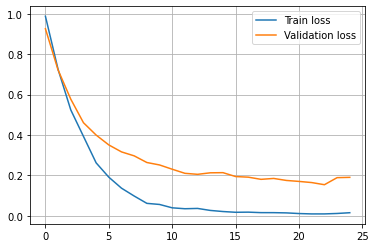

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 25
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_val_loss = 100
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_index, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    # Validate the model
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    if (best_val_loss > val_loss):
        best_val_loss = val_loss
        #torch.save(model.state_dict(), 'saved_model_duration_{}_resnet50.pt'.format(duration))
    if (epoch % 5 == 0):    
        print('Epoch {} train loss: {:.4f} val loss: {:.4f} train accuracy: {:.4f} val accuracy: {:.4f} time: {:.4f} s'.format(
            epoch + 1, train_loss, val_loss, train_accuracy, val_accuracy, time.time() - start_time))

# Plot the loss
plt.plot(train_loss_list, label='Train loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
plt.rcParams["figure.figsize"] = [12, 6]
plt.grid(True)
plt.show()

#### load the saved model

In [34]:
model.load_state_dict(torch.load('saved_model_duration_{}_resnet50.pt'.format(duration)))

<All keys matched successfully>

### evaluate the model on the validation set

In [35]:
print_loader_results(val_loader, model, val_loader_to_dataset_idx)

4 images per patient analysis:
confusion matrix:
[[73.  1.  2.]
 [ 1. 23.  0.]
 [ 3.  1. 24.]]
Accuracy: 0.9375


### evaluate the model on the test set

In [36]:
print_loader_results(test_loader, model, test_loader_to_dataset_idx)

4 images per patient analysis:
confusion matrix:
[[72.  0.  0.]
 [ 2. 21.  1.]
 [ 3.  0. 25.]]
Accuracy: 0.9516129032258065


<span style="font-size:18pt; color:blue">part 3 - Patient Classification using Multiple Scalogram Lengths and FC Neural Network.
 </span>

###### Part 3 focuses on training a patient classifier using the scalograms generated in Part 1 and the trained ResNet models from Part 2. The objective is to collect 76 scalograms from each patient, including four of length 128, eight of length 64, and 64 of length 8 seconds. These scalograms are processed through the corresponding ResNet model trained on the appropriate scalogram length, resulting in three probabilities for each scalogram indicating whether it belongs to an ARR patient, CHF patient, or NSR patient. In total, each patient is represented by a feature vector of 228 values.

##### The combination of different scalogram lengths provides a rich representation of the signal as the short length can reveal short phenomena from one heartbeat to another, while the longer length can demonstrate how the signal changes over a more extended period. Each of the 162 patients is partitioned into training, validation, and test sets, using the original partition from Part 2.

##### The classifier used for this part is a fully connected neural network (FC NN), which is trained on the feature vectors of the training set and validated on the validation set. The accuracy of the system is evaluated on the test set, and it is found that the system only made an incorrect prediction for one patient out of 32 patients. The accuracy of the system is 96.88%, where the one incorrect prediction was for a patient whose ground truth label was ARR, but the system predicted CHF.
###### In most cases, the system correctly predicts the label of the patient with over 99% confidence, indicating high accuracy in the classification task.

In [123]:
def person_data(person_orig_index):
    model_f = models.resnet50(pretrained=True)
    model_f.eval()
    num_features_f = model_f.fc.in_features
    model_f.fc = nn.Linear(num_features_f, num_classes)
    person_data = np.zeros(num_classes * (4 + 8 + 64))
    index_to_insert = 0
    for factor_f in [4,8,64]:
        if factor_f == 4 :
            model_f = models.resnet50(pretrained=True)
            model_f.eval()
            num_features_f = model_f.fc.in_features
            model_f.fc = nn.Linear(num_features_f, num_classes)  
            model_f.load_state_dict(torch.load('saved_model_duration_{}_resnet50.pt'.format(int(512/factor_f))))
        else:
            model_f = models.resnet18(pretrained=True)
            model_f.eval()
            num_features_f = model_f.fc.in_features
            model_f.fc = nn.Linear(num_features_f, num_classes)
            model_f.load_state_dict(torch.load('saved_model_duration_{}_resnet18.pt'.format(int(512/factor_f))))
        root_f = './data_duration_{}_b1.5_c2'.format(int(512/factor_f))
        dataset_f, idx_to_class_f = loadData(root_f)
        person_dataset_indexes_list = [factor_f * person_orig_index + k for k in range(factor_f)]
        for i in person_dataset_indexes_list:
            image = dataset_f[i][0]
            prediction = np.squeeze(evaluate_image(image, model_f).numpy())
            person_data[index_to_insert:index_to_insert + num_classes] = prediction
            index_to_insert += num_classes
    return person_data

In [124]:
def get_persons_data_labels(set_indices):
    complete_persons_labels = [0] * 96 + [1] * 30 + [2] * 36
    set_persons_labels = [complete_persons_labels[index] for index in set_indices]
    set_persons_labels = torch.tensor(set_persons_labels, dtype=torch.int64)
    set_persons_data = np.zeros((len(set_indices), num_classes * (4 + 8 + 64)))
    for i in range(len(set_indices)):
        set_persons_data[i, :] = person_data(set_indices[i])
        print('finished with person indexed', i)
    set_persons_data = torch.tensor(set_persons_data, dtype=torch.float32)
    return (set_persons_data, set_persons_labels)

In [125]:
train_persons_data = torch.load('train_persons_data_4-128_8-64_64-8.pt')
train_persons_labels = torch.load('train_persons_labels_4-128_8-64_64-8.pt')
val_persons_data = torch.load('val_persons_data_4-128_8-64_64-8.pt')
val_persons_labels = torch.load('val_persons_labels_4-128_8-64_64-8.pt')
test_persons_data = torch.load('test_persons_data_4-128_8-64_64-8.pt')
test_persons_labels = torch.load('test_persons_labels_4-128_8-64_64-8.pt')

In [126]:
train_indices = list(range(0, 59)) + list(range(96, 114)) + list(range(126 , 148))
val_indices = list(range(59, 78)) + list(range(114 , 120)) + list(range(148 , 155))
test_indices = list(range(78 , 96 )) + list(range(120 , 126)) + list(range(155,162))

In [127]:
#these lines of code will get the vector features for the patient - these are tensors. it will take a while to get them
#so we loaded them to memory and in the above cell we loaded them from memory.
#run this line of codes of you want to get new tensors - because you want to use more scalograms per patient (now there are 29)
#or because you got other cnn models and want to use them to get better vector features.

#train_persons_data, train_persons_labels = get_persons_data_labels(train_indices)
#val_persons_data, val_persons_labels = get_persons_data_labels(val_indices)
#test_persons_data, test_persons_labels = get_persons_data_labels(test_indices)

In [128]:
print(train_persons_data.shape)
print(train_persons_labels.shape)
print(val_persons_data.shape)
print(val_persons_labels.shape)
print(test_persons_data.shape)
print(test_persons_labels.shape)

torch.Size([99, 228])
torch.Size([99])
torch.Size([32, 228])
torch.Size([32])
torch.Size([31, 228])
torch.Size([31])


In [129]:
#torch.save(train_persons_data, 'train_persons_data_4-128_8-64_64-8.pt')
#torch.save(train_persons_labels, 'train_persons_labels_4-128_8-64_64-8.pt')
#torch.save(val_persons_data, 'val_persons_data_4-128_8-64_64-8.pt')
#torch.save(val_persons_labels, 'val_persons_labels_4-128_8-64_64-8.pt')
#torch.save(test_persons_data, 'test_persons_data_4-128_8-64_64-8.pt')
#torch.save(test_persons_labels, 'test_persons_labels_4-128_8-64_64-8.pt')

In [130]:
class PersonsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

batch_size = 33

fc_train_dataset = PersonsDataset(train_persons_data, train_persons_labels)
fc_train_loader = DataLoader(fc_train_dataset, batch_size=batch_size, shuffle=True)

fc_val_dataset = PersonsDataset(val_persons_data, val_persons_labels)
fc_val_loader = DataLoader(fc_val_dataset, batch_size=1, shuffle=False)

fc_test_dataset = PersonsDataset(test_persons_data, test_persons_labels)
fc_test_loader = DataLoader(fc_test_dataset, batch_size=1, shuffle=False)

In [131]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_classes):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [132]:
fc_classifier = MyModel(228,50,12,3)

Epoch 0 train loss: 1.0904 val loss: 1.0874 train accuracy: 0.5960 val accuracy: 0.5312
Epoch 500 train loss: 0.8678 val loss: 0.8875 train accuracy: 0.7778 val accuracy: 0.6875
Epoch 1000 train loss: 0.5931 val loss: 0.6368 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 1500 train loss: 0.3583 val loss: 0.4190 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 2000 train loss: 0.2078 val loss: 0.2771 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 2500 train loss: 0.1143 val loss: 0.1877 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 3000 train loss: 0.0581 val loss: 0.1321 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 3500 train loss: 0.0278 val loss: 0.1006 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 4000 train loss: 0.0136 val loss: 0.0875 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 4500 train loss: 0.0067 val loss: 0.0838 train accuracy: 1.0000 val accuracy: 0.9688
Epoch 5000 train loss: 0.0032 val loss: 0.0851 train accuracy: 1.0000 val accuracy: 0.9688


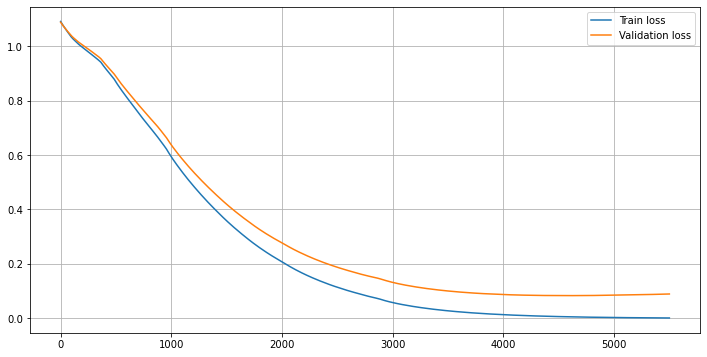

In [133]:
weights = torch.tensor([1/69, 1/18, 1/22])
weighted_loss = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(fc_classifier.parameters(), lr=0.000005)
num_epochs = 5500
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_val_loss = 100
for epoch in range(num_epochs):
    fc_classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_index, (data, labels) in enumerate(fc_train_loader):
        optimizer.zero_grad()
        outputs = fc_classifier(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(fc_train_loader)
    train_accuracy = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    

    # Validate the model
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    fc_classifier.eval()
    with torch.no_grad():
        for data, labels in fc_val_loader:
            outputs = fc_classifier(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(fc_val_loader)
    val_accuracy = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    if (best_val_loss > val_loss):
        best_val_loss = val_loss
        torch.save(fc_classifier.state_dict(), 'saved_model_FC_classifier.pt')
    if (epoch % 500 == 0):    
        print('Epoch {} train loss: {:.4f} val loss: {:.4f} train accuracy: {:.4f} val accuracy: {:.4f}'.format(
            epoch , train_loss, val_loss, train_accuracy, val_accuracy))

# Plot the loss
plt.plot(train_loss_list, label='Train loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
plt.rcParams["figure.figsize"] = [12, 6]
plt.grid(True)
plt.show()

#### load the saved model

In [134]:
fc_classifier.load_state_dict(torch.load('saved_model_FC_classifier.pt'))

<All keys matched successfully>

#### print the test loss and accuracy

In [135]:
test_loss = 0.0
test_correct = 0
test_total = 0
criterion = nn.CrossEntropyLoss()
fc_classifier.eval()
with torch.no_grad():
    for data, labels in fc_test_loader:
        outputs = fc_classifier(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
test_loss /= len(fc_test_loader)
test_accuracy = test_correct / test_total
print ('test accuracy :', test_accuracy)
print ('test loss :' ,test_loss)

test accuracy : 0.967741935483871
test loss : 0.07515227872758143


## test the final model on the test set

In [136]:
np.set_printoptions(precision=3, suppress=True)
fc_classifier.eval()
with torch.no_grad():
    for index, (data, label) in enumerate (fc_test_loader):
        output = fc_classifier(data)
        _, predicted = torch.max(output.data, 1)
        print('index: ',index)
        print("ground truth label :" ,idx_to_class[label.item()])
        print("model prediction:" ,idx_to_class[predicted.item()])
        print("model output:" ,np.squeeze(torch.softmax(output, dim=1).numpy()))

index:  0
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  1
ground truth label : ARR
model prediction: ARR
model output: [0.995 0.002 0.003]
index:  2
ground truth label : ARR
model prediction: ARR
model output: [0.991 0.005 0.004]
index:  3
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  4
ground truth label : ARR
model prediction: ARR
model output: [0.997 0.001 0.002]
index:  5
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  6
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  7
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  8
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  9
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001]
index:  10
ground truth label : ARR
model prediction: ARR
model output: [0.998 0.001 0.001